## 0. Setup

### 0.1. Import

In [1]:
import numpy
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from utils.metrics import accuracy_fn
from utils.visualization import plot_decision_boundary, visualize

### 0.2. Verify GPU Access

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Data

### 1.1. Create a Dataset

In [3]:
n_samples = 1000

X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [4]:
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


### 1.2. Visualize dataset

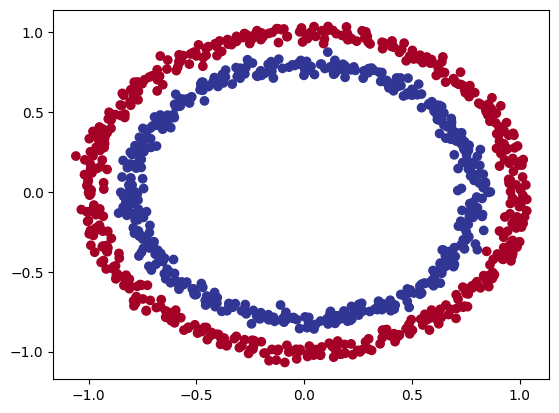

In [5]:
plt.scatter(x=X[:, 0], # x-axis
           y=X[:, 1],  # y-axis
           c=y, # colors based on its label (0 or 1)
           cmap=plt.cm.RdYlBu)

In [6]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

### 1.3. Split data into training & test sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42)

## 2. Build a Model

### 2.1. Model Class Creation
#### **Linear Model (`CircleModelLinear`)**
**Architecture**
- Fully connected layers without activation functions.
- Linear transformations between layers.

**Characteristics**
- Can only learn linear relationships between inputs and outputs.
- Outputs are linearly dependent on inputs.
- Suitable for datasets with simple linear patterns.
- Cannot model complex or non-linear data patterns.

---

#### **Non-Linear Model (`CircleModelNonLinear`)**
**Architecture**
- Fully connected layers with ReLU (Rectified Linear Unit) activation functions.
- Non-linear transformations between layers.

**Characteristics**
- Can learn complex, non-linear relationships.
- Introduces non-linearity after each layer, enabling the model to fit diverse data patterns.
- Suitable for datasets with complex, non-linear patterns (e.g., circular, XOR, spirals).
- Increased model flexibility and capacity to approximate complex functions.

In [8]:
class CircleModelLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.Linear(in_features=10, out_features=10),
            nn.Linear(in_features=10, out_features=1),
        )
    def forward(self, x):
       return self.linear_layer_stack(x)

# identical code, different structure
# class CircleModelLinear(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layer_1 = nn.Linear(in_features=2, out_features=10)
#         self.layer_2 = nn.Linear(in_features=10, out_features=10)
#         self.layer_3 = nn.Linear(in_features=10, out_features=1)

#     def forward(self, x):
#         return self.layer_3(self.layer_2(self.layer_1(x)))

In [9]:
class CircleModelNonLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1),
        )
    def forward(self, x):
       return self.linear_layer_stack(x)

# identical code, different structure
# class CircleModelNonLinear(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layer_1 = nn.Linear(in_features=2, out_features=10)
#         self.layer_2 = nn.Linear(in_features=10, out_features=10)
#         self.layer_3 = nn.Linear(in_features=10, out_features=1)
#         self.relu = nn.ReLU() 
#     def forward(self, x):
#        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [10]:
linear_model = CircleModelLinear().to(device)
non_linear_model = CircleModelNonLinear().to(device)
linear_model, non_linear_model

(CircleModelLinear(
   (linear_layer_stack): Sequential(
     (0): Linear(in_features=2, out_features=10, bias=True)
     (1): Linear(in_features=10, out_features=10, bias=True)
     (2): Linear(in_features=10, out_features=1, bias=True)
   )
 ),
 CircleModelNonLinear(
   (linear_layer_stack): Sequential(
     (0): Linear(in_features=2, out_features=10, bias=True)
     (1): ReLU()
     (2): Linear(in_features=10, out_features=10, bias=True)
     (3): ReLU()
     (4): Linear(in_features=10, out_features=1, bias=True)
   )
 ))

## 3. Training

#### 3.1. Initialize Loss Function & Optimizers

- **Loss Function**: Used `nn.BCEWithLogitsLoss` (Binary Cross-Entropy with Logits) to calculate loss for binary classification tasks, combining a sigmoid layer and the binary cross-entropy loss in a single step for better numerical stability.
- **Optimizers**:
  - `torch.optim.SGD` (Stochastic Gradient Descent) was used with a **learning rate** of `0.1` for optimizing:
    - **`linear_model`**: Parameters of the linear model.
    - **`non_linear_model`**: Parameters of the non-linear model.

In [11]:
loss_fn = nn.BCEWithLogitsLoss() # logits loss has better numerical stability
optimizer1 = torch.optim.SGD(params=linear_model.parameters(), 
                             lr=0.1)
optimizer2 = torch.optim.SGD(params=non_linear_model.parameters(), 
                             lr=0.1)

### 3.2. Optimization Loop

In [12]:
def train_model(model, loss_fn, optimizer, X_train, y_train, X_test, y_test, accuracy_fn, epochs=1000, device='cpu'):
    torch.manual_seed(42)
    
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)
    
    for epoch in range(epochs):
        model.train()
        y_logits = model(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [13]:
# linear model
train_model(
    model=linear_model,
    loss_fn=loss_fn,
    optimizer=optimizer1,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    accuracy_fn=accuracy_fn,
    epochs=2000,
    device=device
)

Epoch: 0 | Loss: 0.69503, Accuracy: 50.00% | Test loss: 0.69332, Test acc: 50.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 51.12% | Test loss: 0.69384, Test acc: 47.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69434, Test acc: 46.50%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69453, Test acc: 47.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69461, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69466, Test acc: 45.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69467, Test acc: 45.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69468, Test acc: 45.50%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 1000 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 1100 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc:

In [14]:
# non-linear model
train_model(
    model=non_linear_model,
    loss_fn=loss_fn,
    optimizer=optimizer2,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    accuracy_fn=accuracy_fn,
    epochs=2000,
    device=device
)

Epoch: 0 | Loss: 0.69753, Accuracy: 50.00% | Test loss: 0.69678, Test acc: 50.00%
Epoch: 100 | Loss: 0.68968, Accuracy: 57.50% | Test loss: 0.69055, Test acc: 56.00%
Epoch: 200 | Loss: 0.68732, Accuracy: 57.38% | Test loss: 0.68955, Test acc: 51.50%
Epoch: 300 | Loss: 0.68428, Accuracy: 56.50% | Test loss: 0.68791, Test acc: 52.00%
Epoch: 400 | Loss: 0.67973, Accuracy: 57.50% | Test loss: 0.68495, Test acc: 51.00%
Epoch: 500 | Loss: 0.67262, Accuracy: 58.75% | Test loss: 0.67925, Test acc: 52.50%
Epoch: 600 | Loss: 0.66123, Accuracy: 61.88% | Test loss: 0.66825, Test acc: 54.00%
Epoch: 700 | Loss: 0.64184, Accuracy: 74.00% | Test loss: 0.64857, Test acc: 70.00%
Epoch: 800 | Loss: 0.60581, Accuracy: 85.12% | Test loss: 0.61404, Test acc: 81.00%
Epoch: 900 | Loss: 0.53413, Accuracy: 92.12% | Test loss: 0.55252, Test acc: 88.50%
Epoch: 1000 | Loss: 0.41386, Accuracy: 97.75% | Test loss: 0.44596, Test acc: 95.50%
Epoch: 1100 | Loss: 0.26520, Accuracy: 99.50% | Test loss: 0.30394, Test acc:

### 3.3. Visualization

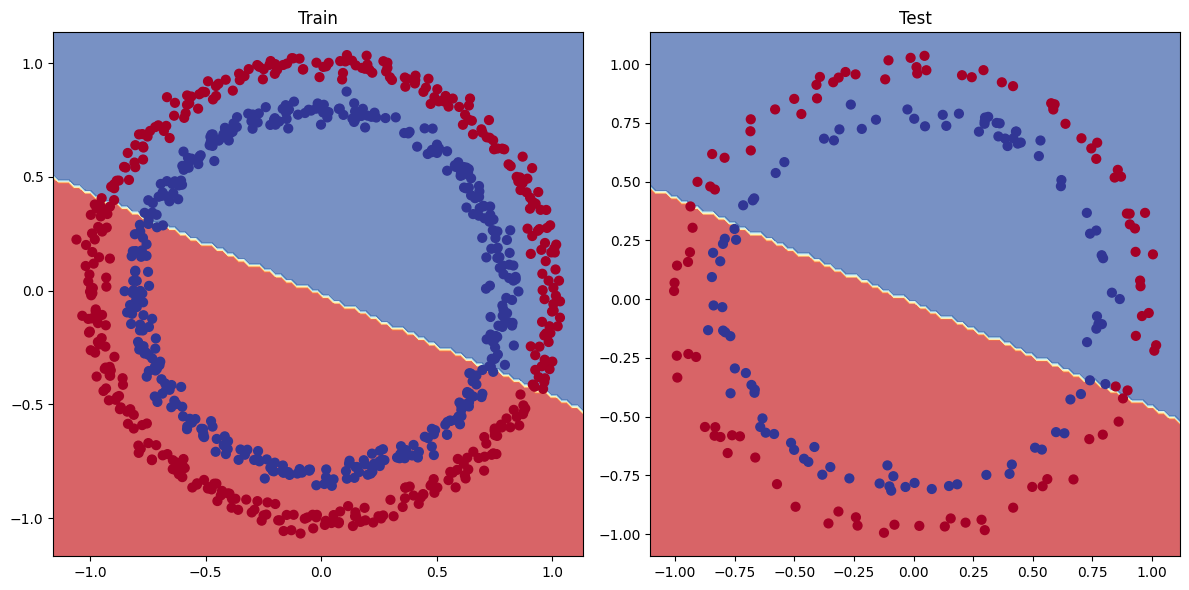

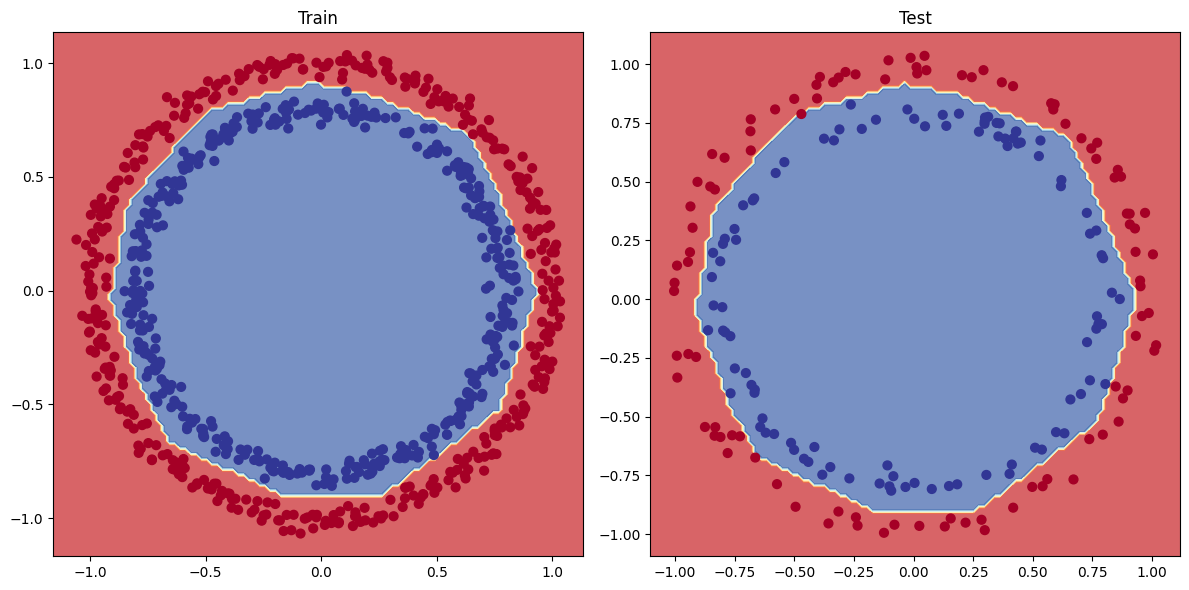

In [15]:
visualize(linear_model, X_train, y_train, X_test, y_test)     # linear
visualize(non_linear_model, X_train, y_train, X_test, y_test) # non-linear